In [133]:
import os
import pandas as pd
from utils import *

In [134]:
DO_FILL_NA = True

In [135]:
RESULTS_MODEL_FOLDER = "Results_model"
RESULTS_BASELINE_FOLDER = "Results"

In [136]:
def get_results_summary(RESULTS_MODEL_FOLDER, mode="models", DO_FILL_NA=True):
    # Initialize results_summary once
    results_summary = pd.DataFrame()

    # List CSV files
    csv_files = [f for f in os.listdir(RESULTS_MODEL_FOLDER) if f.endswith(".csv")]

    for file_name in csv_files:
        df = pd.read_csv(f"{RESULTS_MODEL_FOLDER}/{file_name}")

        if DO_FILL_NA:
            df = df.fillna(0)
        else:
            df = df[df["ANN_RET"] != 0]

        # Parse the file name to extract metadata
        text = file_name.split("_")
        region = text[0]
        non_zero_count = len(df)
        valperiod = text[2]
        testperiod = text[4]

        if mode == "models":
            train_steps = text[6]
            tasksteps = text[8]
            transferstrat = (
                f"{train_steps}_{file_name.split('_transferstrat_')[1].split('_lr')[0]}"
            )
        elif mode == "baseline":
            transferstrat = file_name.split("_baseline_")[1].split(".csv")[0]
            train_steps = None
            tasksteps = None
        else:
            raise ValueError(f"Invalid mode: {mode}")

        # Select test set
        df_test = df[df["set"] == "test"]

        # Columns to analyze
        columns_to_analyze = [
            "SR",
            "CR",
            "MDD",
            "ANN_RET",
            "ANN_VOL",
            "SortR",
            "DownRisk",
            "VaR",
            "TailR",
            "Skew",
            "Kurt",
        ]

        # Dictionary of functions
        func_dict = {"median": pd.Series.median, "mad": mad}

        # Loop over functions and calculate metrics
        for func_name, func in func_dict.items():
            values = [func(df_test[col]) for col in columns_to_analyze]

            # Create Series with metadata + metrics
            series_meta = pd.Series(
                [
                    region,
                    transferstrat,
                    non_zero_count,
                    valperiod,
                    testperiod,
                    train_steps,
                    tasksteps,
                    *values,
                ],
                index=[
                    "region",
                    "transferstrat",
                    "non_zero_count",
                    "valperiod",
                    "testperiod",
                    "train_steps",
                    "tasksteps",
                    *[f"{func_name}_{col}" for col in columns_to_analyze],
                ],
            )

            # Append to results_summary
            results_summary = pd.concat(
                [results_summary, series_meta.to_frame().T], ignore_index=True
            )

    return results_summary

In [137]:
def get_results_grouped(results_summary):
    # Convert all columns except 'region' and 'transferstrat' to numeric
    cols_to_convert = [
        col for col in results_summary.columns if col not in ["region", "transferstrat"]
    ]
    cols_to_convert

    results_summary[cols_to_convert] = results_summary[cols_to_convert].apply(
        pd.to_numeric, errors="coerce"
    )
    results_summary_grouped = results_summary.groupby("transferstrat").mean(
        numeric_only=True
    )
    results_summary_grouped = results_summary_grouped.drop(
        columns=["valperiod", "testperiod", "train_steps", "tasksteps"]
    )
    return results_summary_grouped

In [138]:
results_summary_models = get_results_summary(RESULTS_MODEL_FOLDER)
results_summary_models

,region,transferstrat,non_zero_count,valperiod,testperiod,train_steps,tasksteps,median_SR,median_CR,median_MDD,...,mad_CR,mad_MDD,mad_ANN_RET,mad_ANN_VOL,mad_SortR,mad_DownRisk,mad_VaR,mad_TailR,mad_Skew,mad_Kurt
0,Americas,1000_global_linear_linear,3045,0,756,1000,0,-0.078788,-0.14157,-0.496134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Americas,1000_global_linear_linear,3045,0,756,1000,0,NaN,NaN,NaN,...,0.33194,0.172094,0.148012,0.115911,0.597849,0.081186,0.003337,0.024461,0.91845,19.797915
2,Americas,1000_global_linear_lstm,3045,0,756,1000,0,0.198012,0.099278,-0.155081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Americas,1000_global_linear_lstm,3045,0,756,1000,0,NaN,NaN,NaN,...,0.425413,0.06683,0.061325,0.040054,0.712321,0.028031,0.001239,0.075314,1.303883,23.063364
4,Americas,1000_global_lstm_linear,3045,0,756,1000,0,0.206219,0.119476,-0.113291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,MEA,500_global_lstm_lstm,933,0,756,500,0,NaN,NaN,NaN,...,0.348967,0.099698,0.059191,0.059576,0.688224,0.040542,0.002893,0.056114,0.758526,12.173473
188,MEA,500_no_transfer_linear,933,0,756,500,0,0.228975,0.158639,-0.00866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,MEA,500_no_transfer_linear,933,0,756,500,0,NaN,NaN,NaN,...,0.729363,0.006223,0.004914,0.004006,1.11368,0.002511,0.000208,0.150748,2.184365,33.629237
190,MEA,500_no_transfer_lstm,933,0,756,500,0,0.553879,0.413383,-0.031078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
results_summary_models.columns

Index(['region', 'transferstrat', 'non_zero_count', 'valperiod', 'testperiod',
       'train_steps', 'tasksteps', 'median_SR', 'median_CR', 'median_MDD',
       'median_ANN_RET', 'median_ANN_VOL', 'median_SortR', 'median_DownRisk',
       'median_VaR', 'median_TailR', 'median_Skew', 'median_Kurt', 'mad_SR',
       'mad_CR', 'mad_MDD', 'mad_ANN_RET', 'mad_ANN_VOL', 'mad_SortR',
       'mad_DownRisk', 'mad_VaR', 'mad_TailR', 'mad_Skew', 'mad_Kurt'],
      dtype='object')

In [140]:
results_summary_baseline = get_results_summary(RESULTS_BASELINE_FOLDER, mode="baseline")
results_summary_baseline

,region,transferstrat,non_zero_count,valperiod,testperiod,train_steps,tasksteps,median_SR,median_CR,median_MDD,...,mad_CR,mad_MDD,mad_ANN_RET,mad_ANN_VOL,mad_SortR,mad_DownRisk,mad_VaR,mad_TailR,mad_Skew,mad_Kurt
0,Americas,buy_and_hold,3045,0,756,None,None,0.118111,0.075777,-0.001223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Americas,buy_and_hold,3045,0,756,None,None,NaN,NaN,NaN,...,0.328788,0.00296,0.002881,0.00224,0.592798,0.001433,0.000208,0.010459,0.969609,19.468436
2,Americas,buy_and_hold_shifted_1,3045,0,756,None,None,0.118111,0.075777,-0.001223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Americas,buy_and_hold_shifted_1,3045,0,756,None,None,NaN,NaN,NaN,...,0.328788,0.00296,0.002881,0.00224,0.592798,0.001433,0.000208,0.010459,0.969609,19.468436
4,Americas,csec_mom,3045,0,756,None,None,0.136306,0.081718,-0.001552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,MEA,ts_mom,933,0,756,None,None,NaN,NaN,NaN,...,0.354956,0.033992,0.009736,0.014046,0.6688,0.009805,0.000711,0.044398,1.427185,22.444771
68,MEA,ts_mom_shifted_1,933,0,756,None,None,0.0,0.0,-0.019363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,MEA,ts_mom_shifted_1,933,0,756,None,None,NaN,NaN,NaN,...,0.327126,0.033496,0.009411,0.014002,0.637982,0.009727,0.000716,0.034333,1.423162,21.834659
70,MEA,risk_parity_shifted_1,927,756,756,None,None,0.057793,0.04454,-0.379463,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
results_summary_models_grouped = get_results_grouped(results_summary_models)
results_summary_models_grouped

,non_zero_count,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,...,mad_CR,mad_MDD,mad_ANN_RET,mad_ANN_VOL,mad_SortR,mad_DownRisk,mad_VaR,mad_TailR,mad_Skew,mad_Kurt
transferstrat,,,,,,,,,,,,,,,,,,,,,
1000_global_linear_linear,2212.5,0.133717,-0.003770,-0.412460,-0.005703,0.279922,0.197282,0.193624,-0.027860,1.020536,...,0.561414,0.154686,0.169866,0.110427,0.768043,0.071358,0.004217,0.048533,0.910861,20.960140
1000_global_linear_lstm,2212.5,0.326534,0.204017,-0.156122,0.027692,0.113959,0.475406,0.076970,-0.010674,1.111998,...,0.569224,0.073249,0.069974,0.040706,0.830192,0.028413,0.001746,0.082679,1.299998,22.693792
1000_global_lstm_linear,2212.5,0.255744,0.151990,-0.119962,0.017161,0.085092,0.371770,0.057524,-0.007129,1.106759,...,0.586657,0.065678,0.057289,0.036020,0.876910,0.024582,0.001754,0.089945,1.691315,31.669211
1000_global_lstm_lstm,2212.5,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,...,0.406724,0.102423,0.071082,0.065081,0.716584,0.042492,0.002662,0.044483,1.005708,20.760783
1000_no_transfer_linear,2212.5,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,...,0.494823,0.006046,0.003507,0.003147,0.860725,0.002064,0.000141,0.082787,2.190449,37.595666
1000_no_transfer_lstm,2212.5,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,...,0.457963,0.082652,0.043577,0.050545,0.714499,0.035427,0.003912,0.073375,1.406821,25.898575
100_global_linear_linear,2212.5,0.105507,-0.010954,-0.376063,-0.008202,0.248365,0.152422,0.171869,-0.024329,1.020103,...,0.586688,0.152568,0.158516,0.099719,0.815673,0.064828,0.004299,0.054979,0.999320,20.832478
100_global_linear_lstm,2212.5,0.221088,0.120073,-0.201383,0.012483,0.141488,0.325089,0.096100,-0.014356,1.041386,...,0.554335,0.110043,0.090826,0.070294,0.802113,0.045665,0.003148,0.075668,1.169699,22.715117
100_global_lstm_linear,2212.5,0.303546,0.187347,-0.235234,0.029622,0.167133,0.452207,0.112523,-0.016157,1.090989,...,0.625633,0.109725,0.112901,0.071523,0.839078,0.044650,0.002989,0.064199,1.046029,20.160798


In [142]:
results_summary_baseline_grouped = get_results_grouped(
    results_summary=results_summary_baseline
)
results_summary_baseline_grouped

,non_zero_count,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,...,mad_CR,mad_MDD,mad_ANN_RET,mad_ANN_VOL,mad_SortR,mad_DownRisk,mad_VaR,mad_TailR,mad_Skew,mad_Kurt
transferstrat,,,,,,,,,,,,,,,,,,,,,
buy_and_hold,2212.500,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,...,0.381749,0.009528,0.004662,0.005852,0.713378,0.003772,0.000435,0.048074,0.998366,20.401205
buy_and_hold_shifted_1,2212.500,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,...,0.381749,0.009528,0.004662,0.005852,0.713378,0.003772,0.000435,0.048074,0.998366,20.401205
csec_mom,2212.500,0.111975,0.067837,-0.011514,0.000413,0.006969,0.177557,0.004634,-0.000683,1.011165,...,0.347669,0.024686,0.006882,0.012296,0.703739,0.007996,0.000656,0.040403,1.688158,29.793738
csec_mom_shifted_1,2212.500,0.106569,0.066042,-0.011378,0.000331,0.006941,0.172247,0.004613,-0.000686,1.003262,...,0.331888,0.024424,0.006436,0.012166,0.678762,0.007853,0.000660,0.039993,1.674302,28.952774
risk_parity,2212.500,0.188464,0.121219,-0.007470,0.000959,0.005141,0.277423,0.003494,-0.000436,1.047438,...,0.393940,0.009420,0.004542,0.005275,0.721400,0.003675,0.000433,0.056269,1.217340,25.813705
risk_parity_shifted_1,2205.375,0.179810,0.129079,-0.182207,0.023694,0.136686,0.359763,0.093094,-0.012539,1.054071,...,0.398257,0.059617,0.063414,0.028014,0.687595,0.018444,0.002335,0.046201,1.083143,19.671715
ts_mom,2212.500,0.116319,0.070834,-0.010516,0.000372,0.006090,0.182053,0.004113,-0.000589,1.006851,...,0.339462,0.021269,0.006065,0.010518,0.684502,0.006813,0.000570,0.038368,1.390254,24.310985
ts_mom_shifted_1,2212.500,0.100525,0.062620,-0.010653,0.000306,0.006096,0.155158,0.004066,-0.000592,1.004406,...,0.319148,0.021077,0.005691,0.010413,0.661112,0.006671,0.000572,0.037005,1.371931,23.735569


In [143]:
results_grouped = pd.concat(
    [results_summary_models_grouped, results_summary_baseline_grouped]
)
results_grouped

,non_zero_count,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,...,mad_CR,mad_MDD,mad_ANN_RET,mad_ANN_VOL,mad_SortR,mad_DownRisk,mad_VaR,mad_TailR,mad_Skew,mad_Kurt
transferstrat,,,,,,,,,,,,,,,,,,,,,
1000_global_linear_linear,2212.500,0.133717,-0.003770,-0.412460,-0.005703,0.279922,0.197282,0.193624,-0.027860,1.020536,...,0.561414,0.154686,0.169866,0.110427,0.768043,0.071358,0.004217,0.048533,0.910861,20.960140
1000_global_linear_lstm,2212.500,0.326534,0.204017,-0.156122,0.027692,0.113959,0.475406,0.076970,-0.010674,1.111998,...,0.569224,0.073249,0.069974,0.040706,0.830192,0.028413,0.001746,0.082679,1.299998,22.693792
1000_global_lstm_linear,2212.500,0.255744,0.151990,-0.119962,0.017161,0.085092,0.371770,0.057524,-0.007129,1.106759,...,0.586657,0.065678,0.057289,0.036020,0.876910,0.024582,0.001754,0.089945,1.691315,31.669211
1000_global_lstm_lstm,2212.500,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,...,0.406724,0.102423,0.071082,0.065081,0.716584,0.042492,0.002662,0.044483,1.005708,20.760783
1000_no_transfer_linear,2212.500,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,...,0.494823,0.006046,0.003507,0.003147,0.860725,0.002064,0.000141,0.082787,2.190449,37.595666
1000_no_transfer_lstm,2212.500,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,...,0.457963,0.082652,0.043577,0.050545,0.714499,0.035427,0.003912,0.073375,1.406821,25.898575
100_global_linear_linear,2212.500,0.105507,-0.010954,-0.376063,-0.008202,0.248365,0.152422,0.171869,-0.024329,1.020103,...,0.586688,0.152568,0.158516,0.099719,0.815673,0.064828,0.004299,0.054979,0.999320,20.832478
100_global_linear_lstm,2212.500,0.221088,0.120073,-0.201383,0.012483,0.141488,0.325089,0.096100,-0.014356,1.041386,...,0.554335,0.110043,0.090826,0.070294,0.802113,0.045665,0.003148,0.075668,1.169699,22.715117
100_global_lstm_linear,2212.500,0.303546,0.187347,-0.235234,0.029622,0.167133,0.452207,0.112523,-0.016157,1.090989,...,0.625633,0.109725,0.112901,0.071523,0.839078,0.044650,0.002989,0.064199,1.046029,20.160798


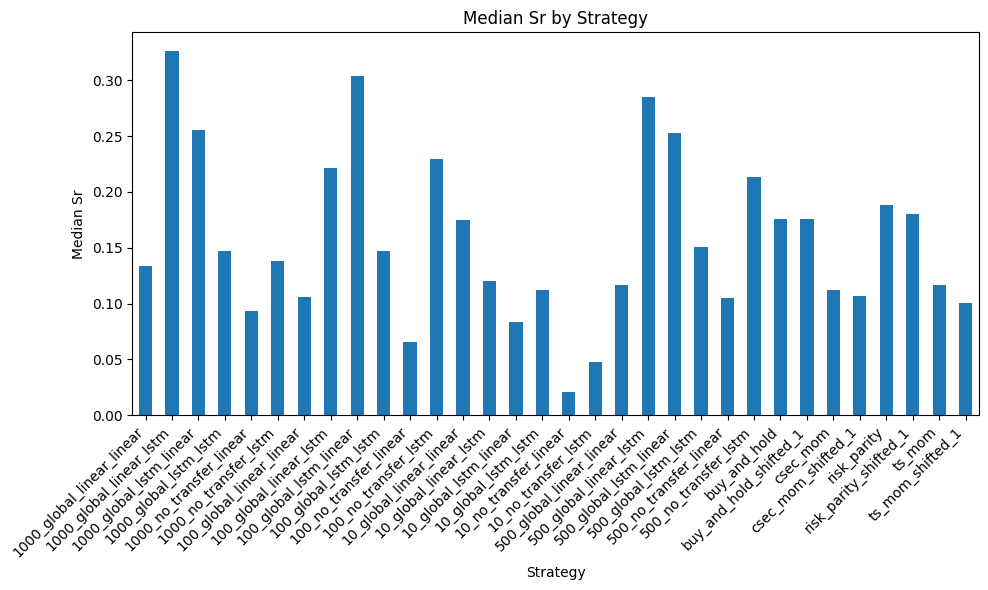

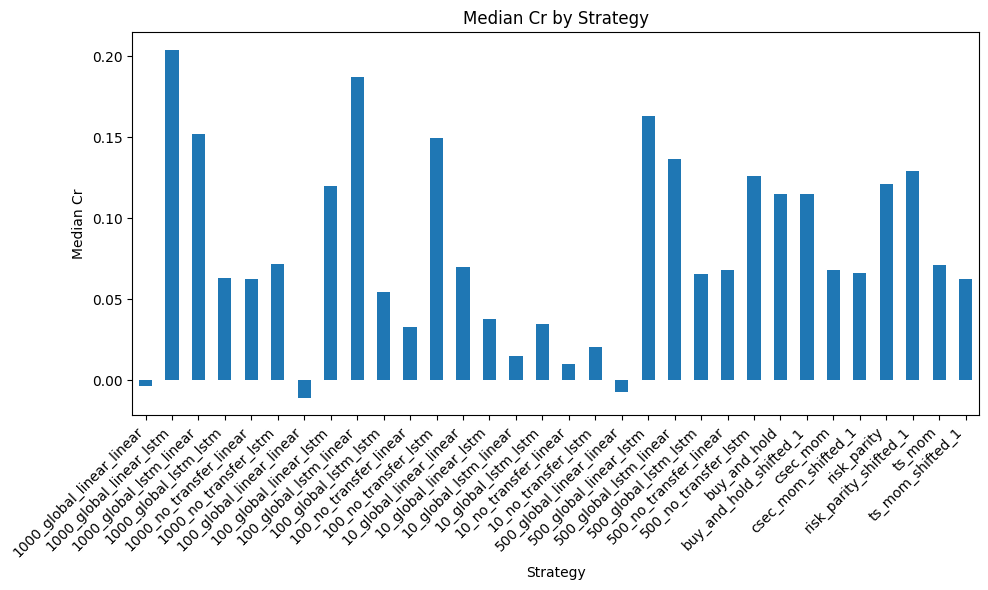

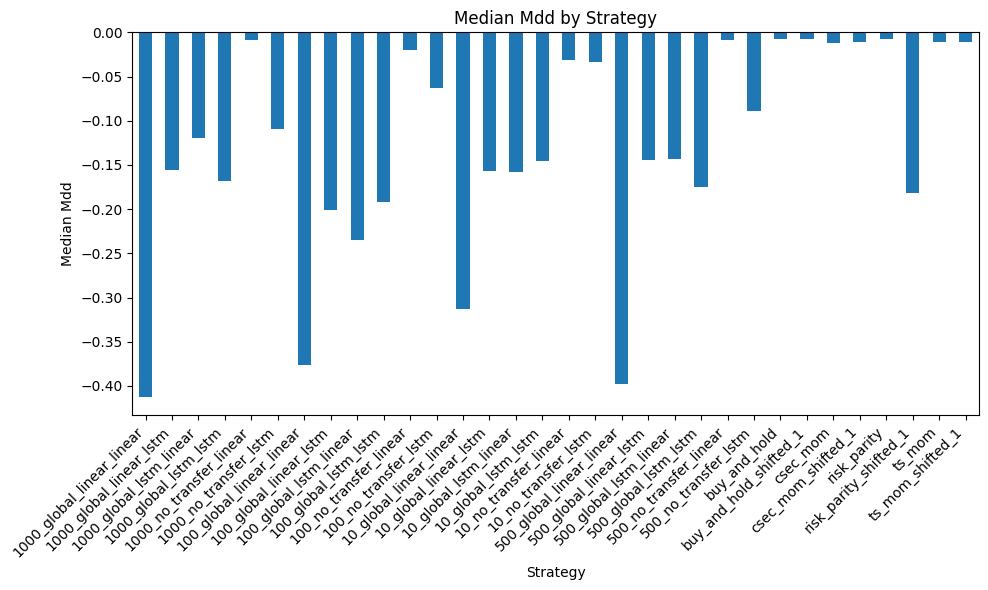

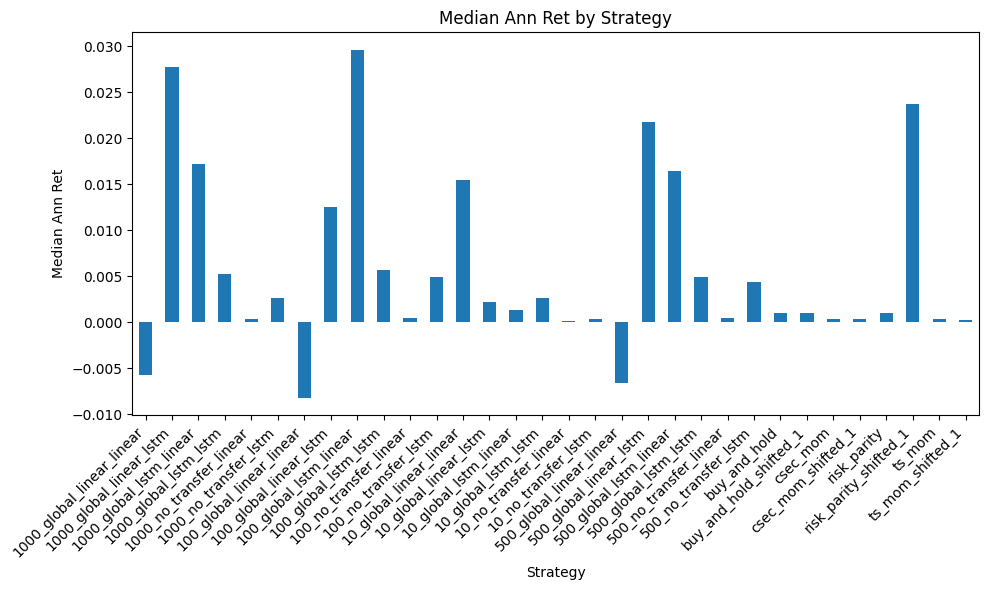

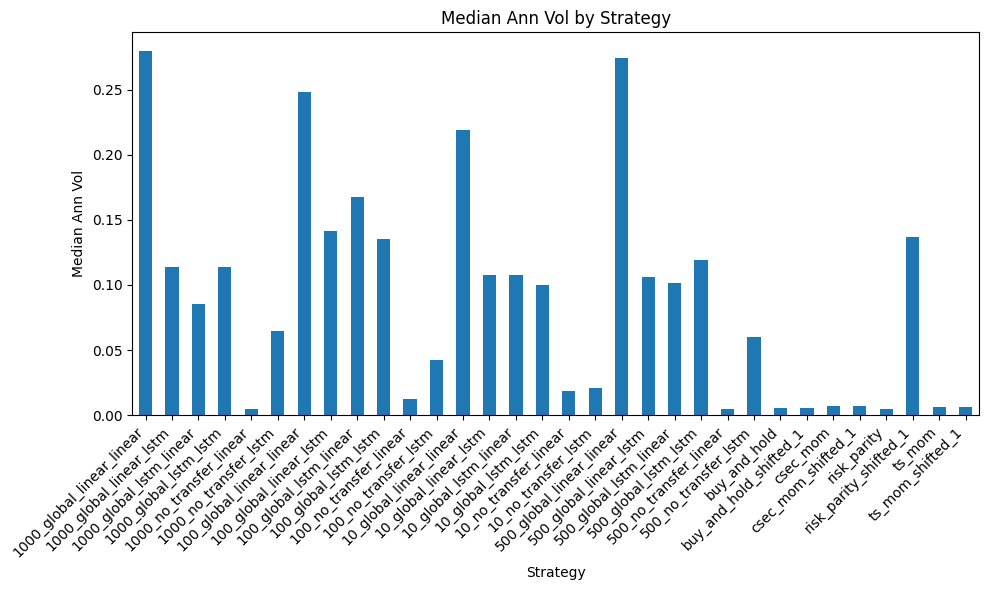

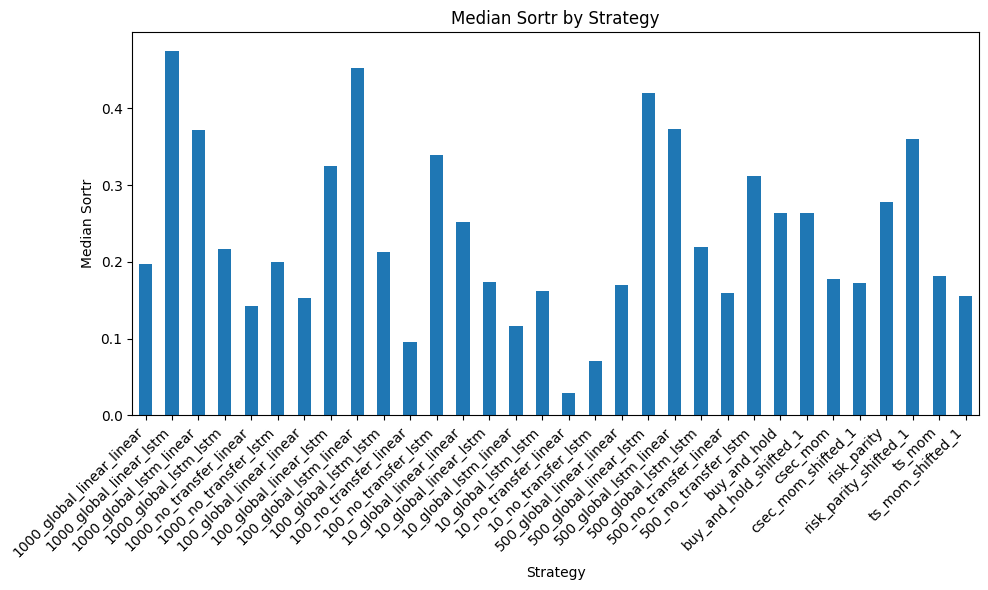

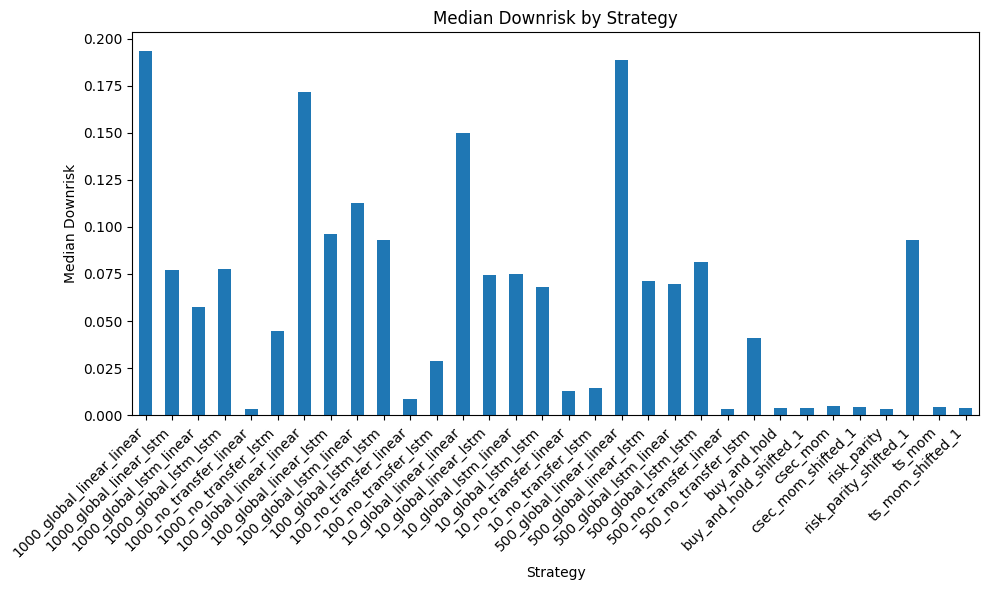

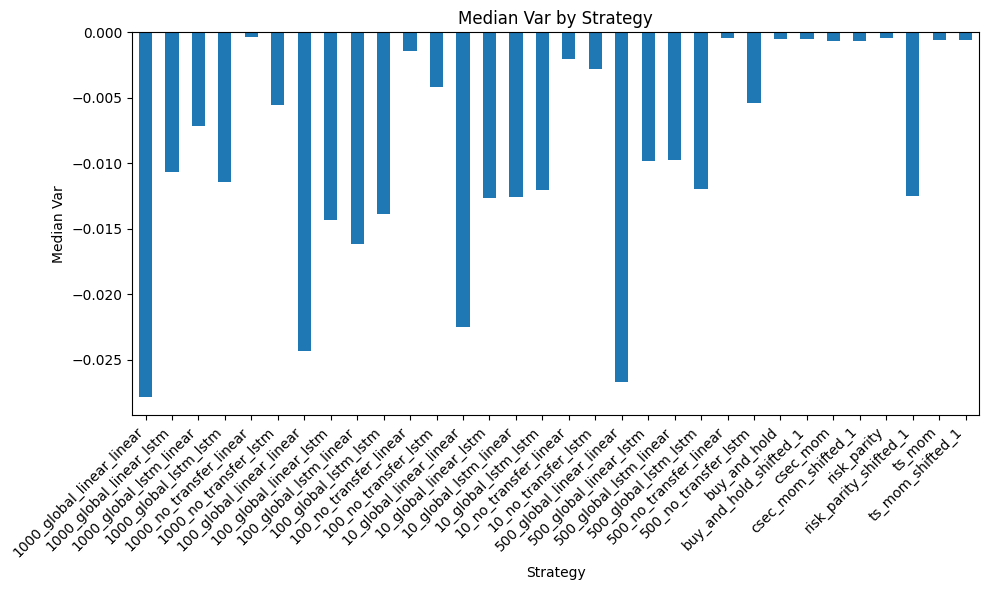

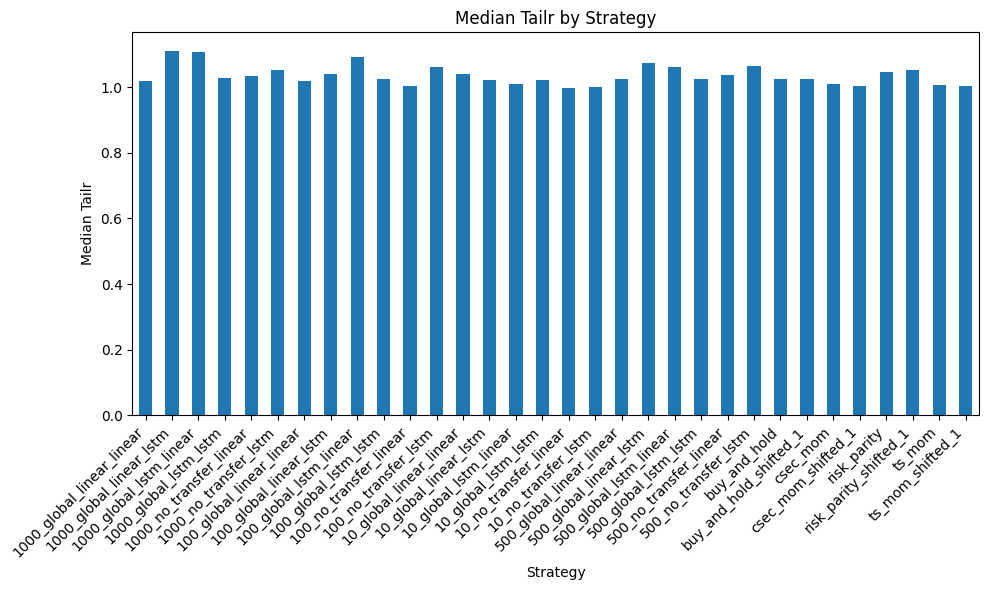

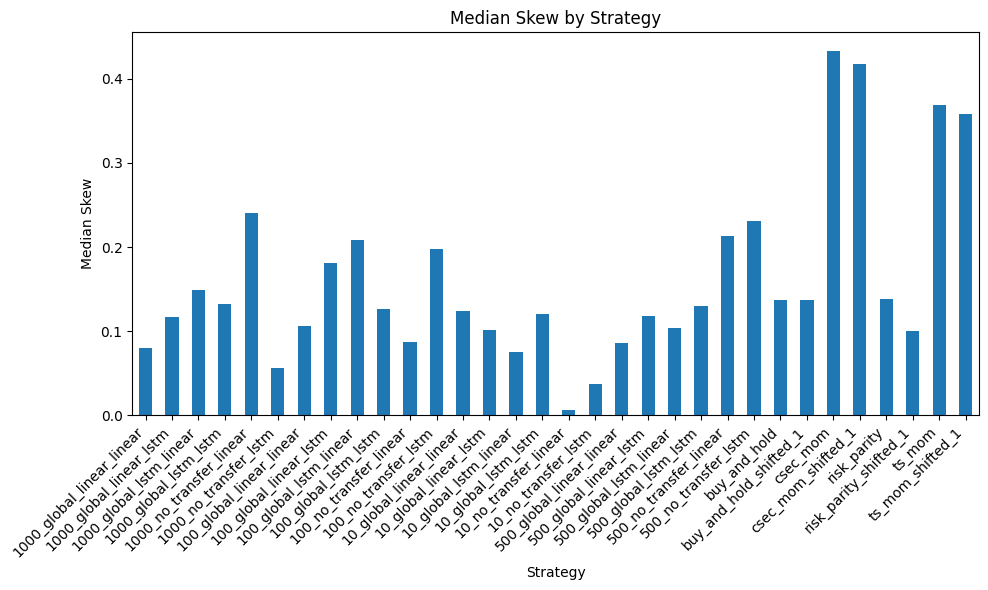

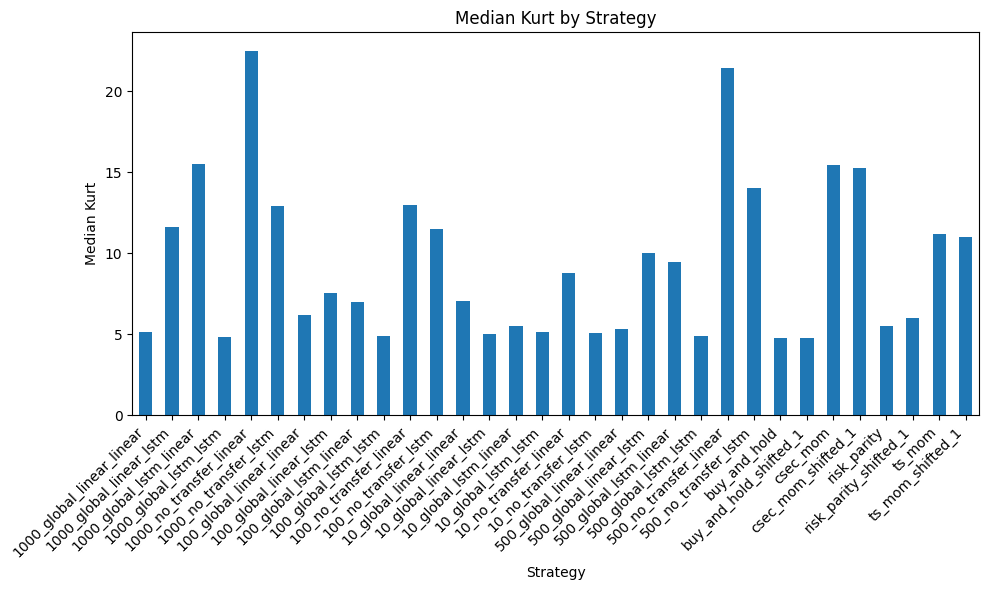

In [144]:
import matplotlib.pyplot as plt

# Automatically select median columns
median_metrics = [col for col in results_grouped.columns if col.startswith("median_")]

for metric in median_metrics:
    plt.figure(figsize=(10, 6))
    results_grouped[metric].plot(kind="bar")
    plt.title(f"{metric.replace('_', ' ').title()} by Strategy")
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel("Strategy")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [145]:
results_grouped_rank = results_grouped.copy()
positive_rank_metrics = [
    "median_sharpe_ratio",
    "median_calmar_ratio",
    "median_annual_return",
    "median_sortino_ratio",
]

for metric in positive_rank_metrics:
    results_grouped_rank[metric] = results_grouped_rank[metric].rank(
        ascending=False, method="min"
    )

negative_rank_metrics = [
    "median_maximum_draw_down",
    "median_volatility",
    "median_down_risk",
    "median_value_at_risk",
    "median_tail_risk",
]

rank_metrics = positive_rank_metrics + negative_rank_metrics
for metric in negative_rank_metrics:
    results_grouped_rank[metric] = results_grouped_rank[metric].rank(
        ascending=True, method="min"
    )

results_grouped_rank = results_grouped_rank[rank_metrics]
results_grouped_rank

KeyError: 'median_sharpe_ratio'

In [ ]:
results_grouped_rank_total = results_grouped_rank.sum(axis=1)
results_grouped_rank_total

transferstrat
1000_global_linear_linear    172.0
1000_global_linear_lstm      109.0
1000_global_lstm_linear      115.0
1000_global_lstm_lstm        146.0
1000_no_transfer_linear      184.0
1000_no_transfer_lstm        151.0
100_global_linear_linear     191.0
100_global_linear_lstm       121.0
100_global_lstm_linear       103.0
100_global_lstm_lstm         144.0
100_no_transfer_linear       178.0
100_no_transfer_lstm         122.0
10_global_linear_linear      135.0
10_global_linear_lstm        151.0
10_global_lstm_linear        173.0
10_global_lstm_lstm          158.0
10_no_transfer_linear        189.0
10_no_transfer_lstm          182.0
500_global_linear_linear     184.0
500_global_linear_lstm       110.0
500_global_lstm_linear       115.0
500_global_lstm_lstm         145.0
500_no_transfer_linear       171.0
500_no_transfer_lstm         132.0
buy_and_hold                 131.0
buy_and_hold_shifted_1       131.0
csec_mom                     156.0
csec_mom_shifted_1           159.0
risk_p

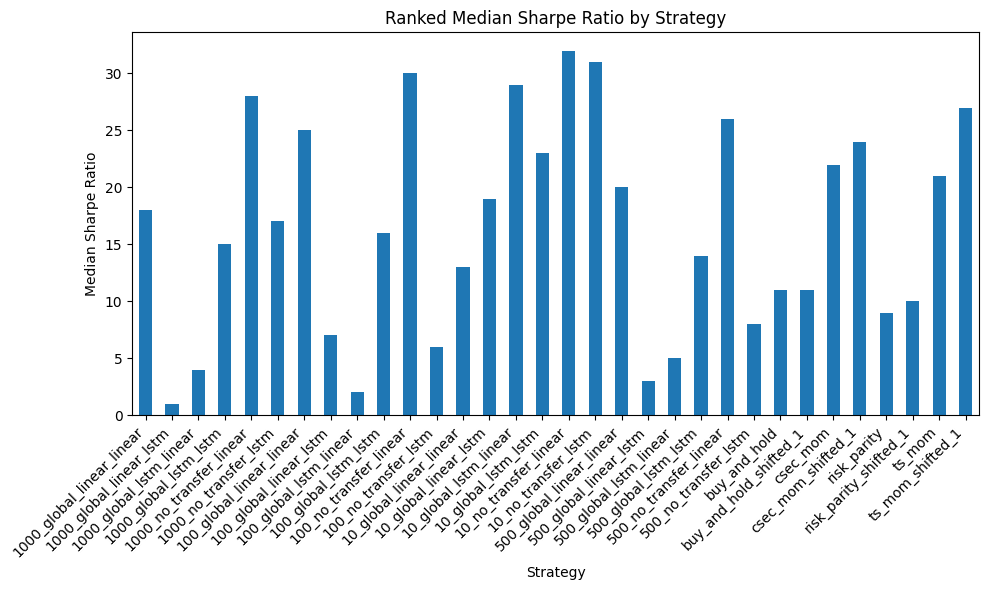

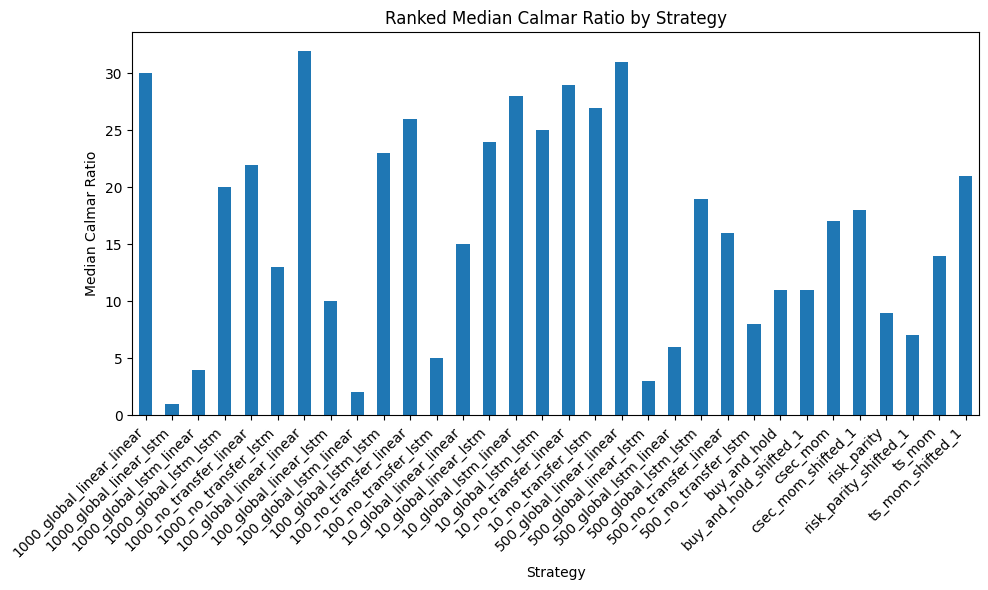

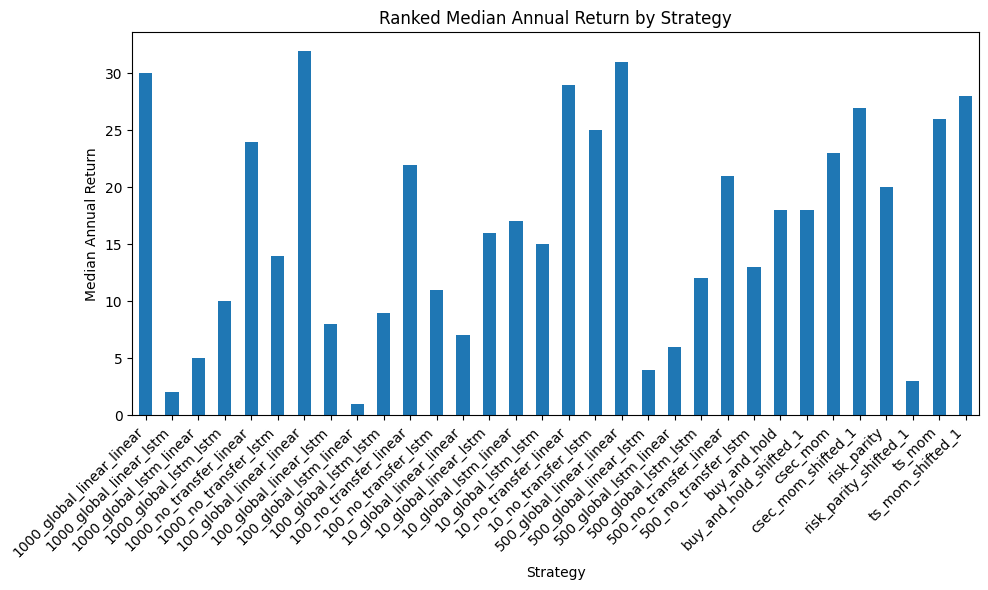

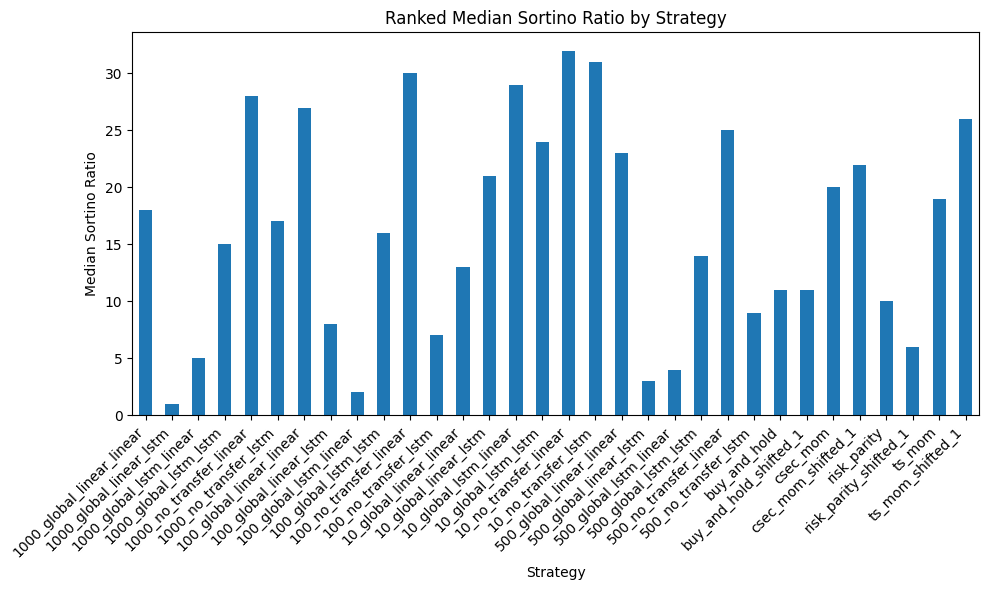

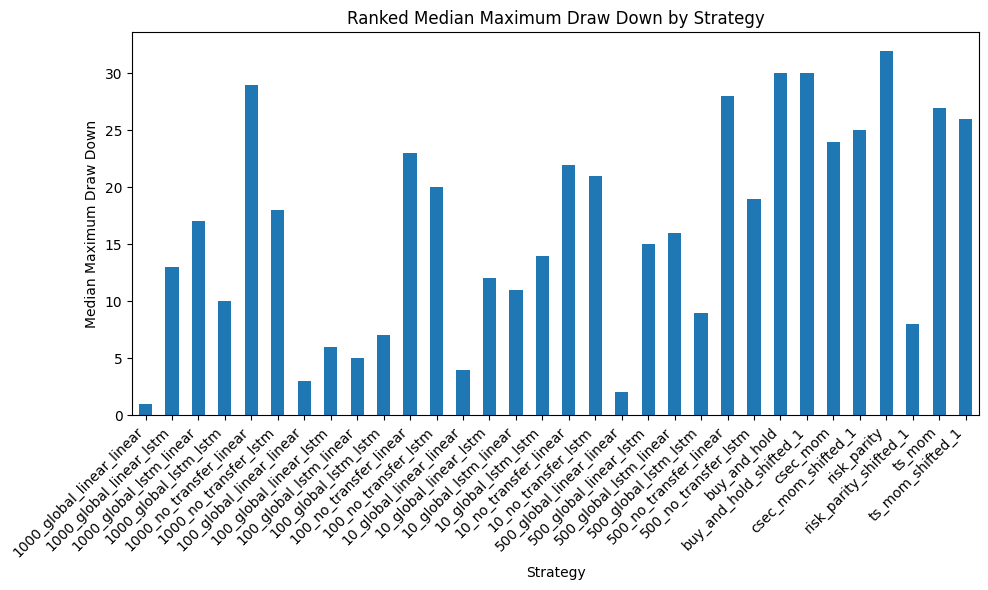

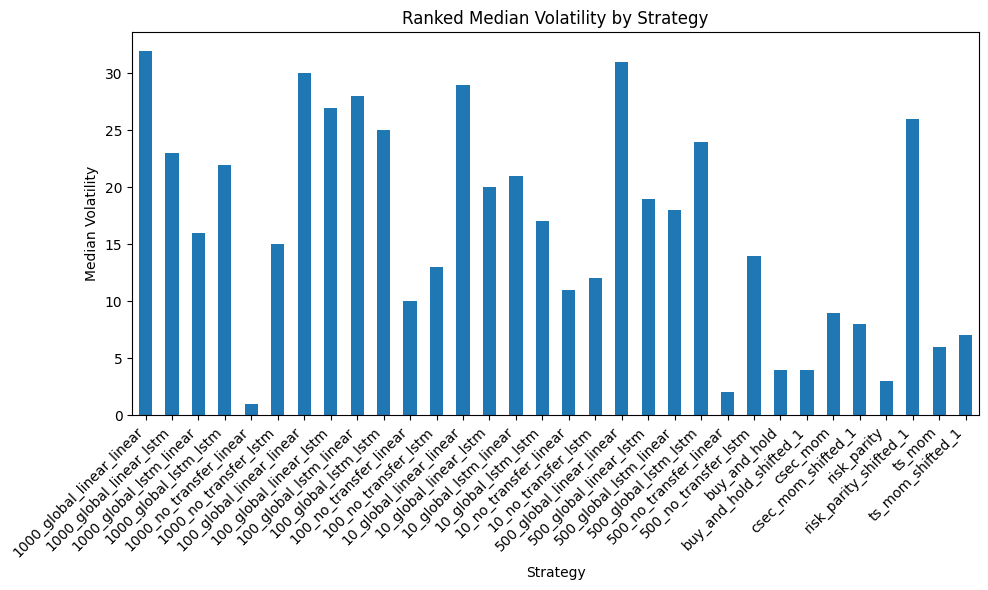

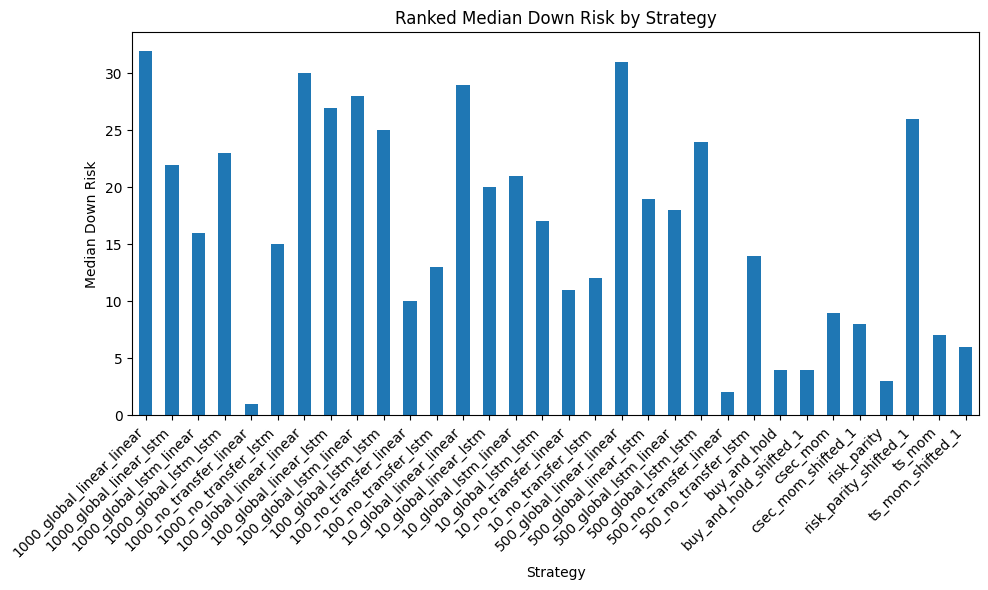

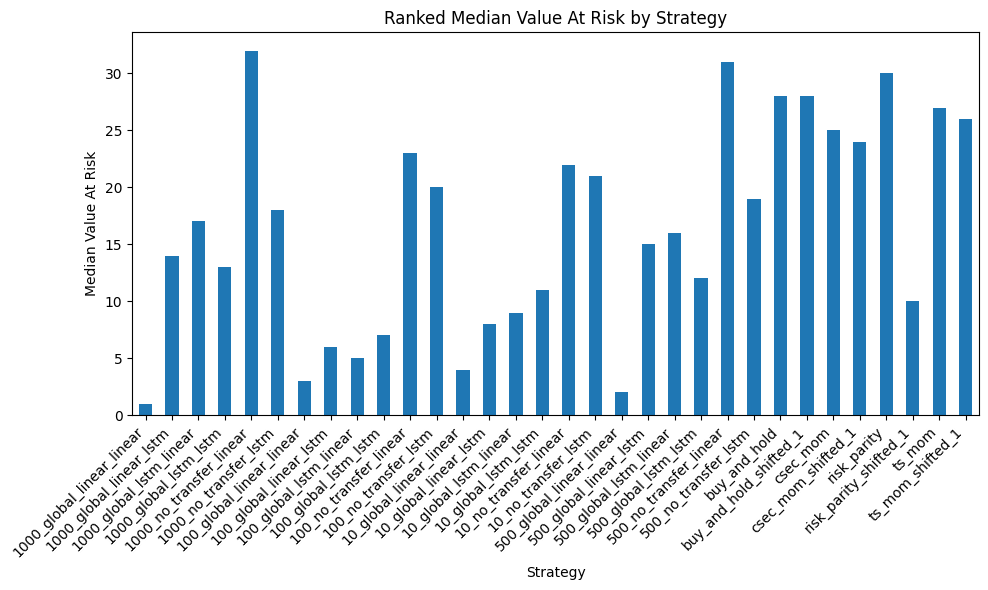

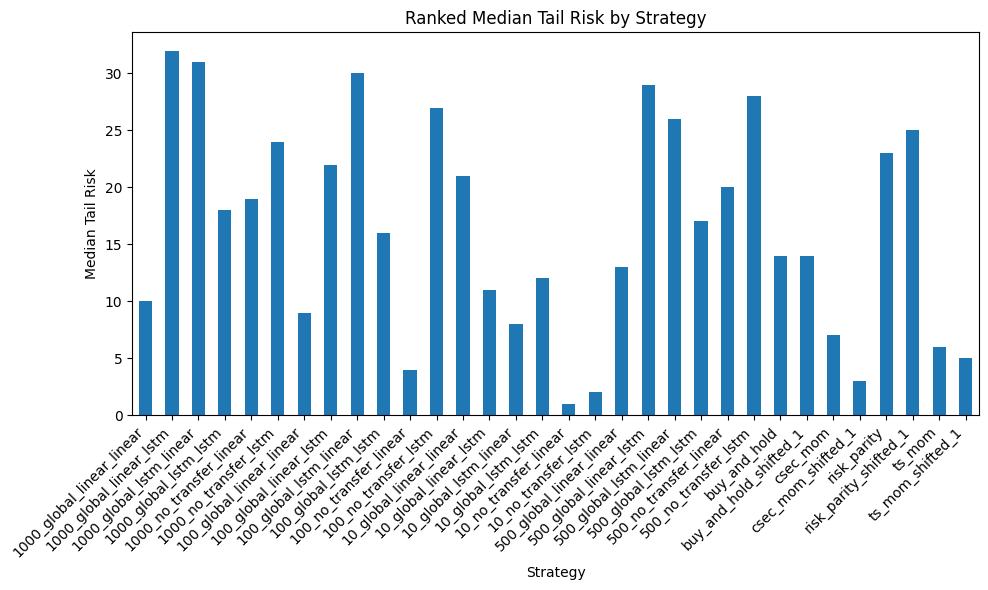

In [ ]:
for metric in rank_metrics:
    plt.figure(figsize=(10, 6))
    results_grouped_rank[metric].plot(kind="bar")
    plt.title(f"Ranked {metric.replace('_', ' ').title()} by Strategy")
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel("Strategy")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

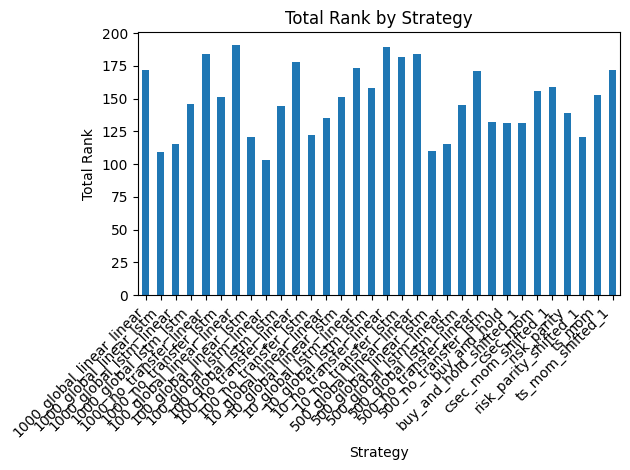

In [ ]:
results_grouped_rank_total.plot(kind="bar")
plt.title("Total Rank by Strategy")
plt.ylabel("Total Rank")
plt.xlabel("Strategy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
results_summary_baseline_grouped

,non_zero_count,median_sharpe_ratio,median_calmar_ratio,median_maximum_draw_down,median_annual_return,median_volatility,median_sortino_ratio,median_down_risk,median_value_at_risk,median_tail_risk,...,mad_calmar_ratio,mad_maximum_draw_down,mad_annual_return,mad_volatility,mad_sortino_ratio,mad_down_risk,mad_value_at_risk,mad_tail_risk,mad_skew,mad_kurtosis
transferstrat,,,,,,,,,,,,,,,,,,,,,
buy_and_hold,2212.500,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,...,0.381749,0.009528,0.004662,0.005852,0.713378,0.003772,0.000435,0.048074,0.998366,20.401205
buy_and_hold_shifted_1,2212.500,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,...,0.381749,0.009528,0.004662,0.005852,0.713378,0.003772,0.000435,0.048074,0.998366,20.401205
csec_mom,2212.500,0.111975,0.067837,-0.011514,0.000413,0.006969,0.177557,0.004634,-0.000683,1.011165,...,0.347669,0.024686,0.006882,0.012296,0.703739,0.007996,0.000656,0.040403,1.688158,29.793738
csec_mom_shifted_1,2212.500,0.106569,0.066042,-0.011378,0.000331,0.006941,0.172247,0.004613,-0.000686,1.003262,...,0.331888,0.024424,0.006436,0.012166,0.678762,0.007853,0.000660,0.039993,1.674302,28.952774
risk_parity,2212.500,0.188464,0.121219,-0.007470,0.000959,0.005141,0.277423,0.003494,-0.000436,1.047438,...,0.393940,0.009420,0.004542,0.005275,0.721400,0.003675,0.000433,0.056269,1.217340,25.813705
risk_parity_shifted_1,2205.375,0.179810,0.129079,-0.182207,0.023694,0.136686,0.359763,0.093094,-0.012539,1.054071,...,0.398257,0.059617,0.063414,0.028014,0.687595,0.018444,0.002335,0.046201,1.083143,19.671715
ts_mom,2212.500,0.116319,0.070834,-0.010516,0.000372,0.006090,0.182053,0.004113,-0.000589,1.006851,...,0.339462,0.021269,0.006065,0.010518,0.684502,0.006813,0.000570,0.038368,1.390254,24.310985
ts_mom_shifted_1,2212.500,0.100525,0.062620,-0.010653,0.000306,0.006096,0.155158,0.004066,-0.000592,1.004406,...,0.319148,0.021077,0.005691,0.010413,0.661112,0.006671,0.000572,0.037005,1.371931,23.735569


In [ ]:
results_summary_models_grouped

,non_zero_count,median_sharpe_ratio,median_calmar_ratio,median_maximum_draw_down,median_annual_return,median_volatility,median_sortino_ratio,median_down_risk,median_value_at_risk,median_tail_risk,...,mad_calmar_ratio,mad_maximum_draw_down,mad_annual_return,mad_volatility,mad_sortino_ratio,mad_down_risk,mad_value_at_risk,mad_tail_risk,mad_skew,mad_kurtosis
transferstrat,,,,,,,,,,,,,,,,,,,,,
1000_global_linear_linear,2212.5,0.133717,-0.003770,-0.412460,-0.005703,0.279922,0.197282,0.193624,-0.027860,1.020536,...,0.561414,0.154686,0.169866,0.110427,0.768043,0.071358,0.004217,0.048533,0.910861,20.960140
1000_global_linear_lstm,2212.5,0.326534,0.204017,-0.156122,0.027692,0.113959,0.475406,0.076970,-0.010674,1.111998,...,0.569224,0.073249,0.069974,0.040706,0.830192,0.028413,0.001746,0.082679,1.299998,22.693792
1000_global_lstm_linear,2212.5,0.255744,0.151990,-0.119962,0.017161,0.085092,0.371770,0.057524,-0.007129,1.106759,...,0.586657,0.065678,0.057289,0.036020,0.876910,0.024582,0.001754,0.089945,1.691315,31.669211
1000_global_lstm_lstm,2212.5,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,...,0.406724,0.102423,0.071082,0.065081,0.716584,0.042492,0.002662,0.044483,1.005708,20.760783
1000_no_transfer_linear,2212.5,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,...,0.494823,0.006046,0.003507,0.003147,0.860725,0.002064,0.000141,0.082787,2.190449,37.595666
1000_no_transfer_lstm,2212.5,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,...,0.457963,0.082652,0.043577,0.050545,0.714499,0.035427,0.003912,0.073375,1.406821,25.898575
100_global_linear_linear,2212.5,0.105507,-0.010954,-0.376063,-0.008202,0.248365,0.152422,0.171869,-0.024329,1.020103,...,0.586688,0.152568,0.158516,0.099719,0.815673,0.064828,0.004299,0.054979,0.999320,20.832478
100_global_linear_lstm,2212.5,0.221088,0.120073,-0.201383,0.012483,0.141488,0.325089,0.096100,-0.014356,1.041386,...,0.554335,0.110043,0.090826,0.070294,0.802113,0.045665,0.003148,0.075668,1.169699,22.715117
100_global_lstm_linear,2212.5,0.303546,0.187347,-0.235234,0.029622,0.167133,0.452207,0.112523,-0.016157,1.090989,...,0.625633,0.109725,0.112901,0.071523,0.839078,0.044650,0.002989,0.064199,1.046029,20.160798


In [ ]:
results_summary_models_grouped.loc[
    ["1000_global_lstm_lstm", "1000_no_transfer_linear", "1000_no_transfer_lstm"]
]

,non_zero_count,median_sharpe_ratio,median_calmar_ratio,median_maximum_draw_down,median_annual_return,median_volatility,median_sortino_ratio,median_down_risk,median_value_at_risk,median_tail_risk,...,mad_calmar_ratio,mad_maximum_draw_down,mad_annual_return,mad_volatility,mad_sortino_ratio,mad_down_risk,mad_value_at_risk,mad_tail_risk,mad_skew,mad_kurtosis
transferstrat,,,,,,,,,,,,,,,,,,,,,
1000_global_lstm_lstm,2212.5,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,...,0.406724,0.102423,0.071082,0.065081,0.716584,0.042492,0.002662,0.044483,1.005708,20.760783
1000_no_transfer_linear,2212.5,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,...,0.494823,0.006046,0.003507,0.003147,0.860725,0.002064,0.000141,0.082787,2.190449,37.595666
1000_no_transfer_lstm,2212.5,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,...,0.457963,0.082652,0.043577,0.050545,0.714499,0.035427,0.003912,0.073375,1.406821,25.898575


In [ ]:
def get_table_1(results_summary_baseline_grouped, results_summary_models_grouped):
    cleaned_results_summary_baseline_grouped = results_summary_baseline_grouped[
        ~results_summary_baseline_grouped.index.astype(str).str.endswith("shifted_1")
    ]
    cleaned_results_summary_baseline_grouped = (
        cleaned_results_summary_baseline_grouped.drop(columns=["non_zero_count"])
    )

    cleaned_results_summary_models_grouped = results_summary_models_grouped.loc[
        ["1000_global_lstm_lstm", "1000_no_transfer_linear", "1000_no_transfer_lstm"]
    ]

    output_df = pd.concat(
        [
            cleaned_results_summary_baseline_grouped,
            cleaned_results_summary_models_grouped,
        ]
    )
    output_df = output_df.rename(
        index={
            "buy_and_hold": "Buy and hold",
            "risk_parity": "Risk_parity",
            "ts_mom": "TS Mom",
            "csec_mom": "CS Mom",
            "1000_no_transfer_linear": "No Transfer Linear",
            "1000_no_transfer_lstm": "No Transfer LSTM",
            "1000_global_lstm_lstm": "QuantNet",
        }
    )

    return output_df

In [ ]:
table_1 = get_table_1(results_summary_baseline_grouped, results_summary_models_grouped)
table_1.to_csv("table_1.csv")
table_1

,median_sharpe_ratio,median_calmar_ratio,median_maximum_draw_down,median_annual_return,median_volatility,median_sortino_ratio,median_down_risk,median_value_at_risk,median_tail_risk,median_skew,...,mad_maximum_draw_down,mad_annual_return,mad_volatility,mad_sortino_ratio,mad_down_risk,mad_value_at_risk,mad_tail_risk,mad_skew,mad_kurtosis,non_zero_count
transferstrat,,,,,,,,,,,,,,,,,,,,,
Buy and hold,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,0.136432,...,0.009528,0.004662,0.005852,0.713378,0.003772,0.000435,0.048074,0.998366,20.401205,NaN
CS Mom,0.111975,0.067837,-0.011514,0.000413,0.006969,0.177557,0.004634,-0.000683,1.011165,0.433594,...,0.024686,0.006882,0.012296,0.703739,0.007996,0.000656,0.040403,1.688158,29.793738,NaN
Risk_parity,0.188464,0.121219,-0.007470,0.000959,0.005141,0.277423,0.003494,-0.000436,1.047438,0.138006,...,0.009420,0.004542,0.005275,0.721400,0.003675,0.000433,0.056269,1.217340,25.813705,NaN
TS Mom,0.116319,0.070834,-0.010516,0.000372,0.006090,0.182053,0.004113,-0.000589,1.006851,0.368555,...,0.021269,0.006065,0.010518,0.684502,0.006813,0.000570,0.038368,1.390254,24.310985,NaN
QuantNet,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,0.132192,...,0.102423,0.071082,0.065081,0.716584,0.042492,0.002662,0.044483,1.005708,20.760783,2212.5
No Transfer Linear,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,0.240033,...,0.006046,0.003507,0.003147,0.860725,0.002064,0.000141,0.082787,2.190449,37.595666,2212.5
No Transfer LSTM,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,0.056026,...,0.082652,0.043577,0.050545,0.714499,0.035427,0.003912,0.073375,1.406821,25.898575,2212.5


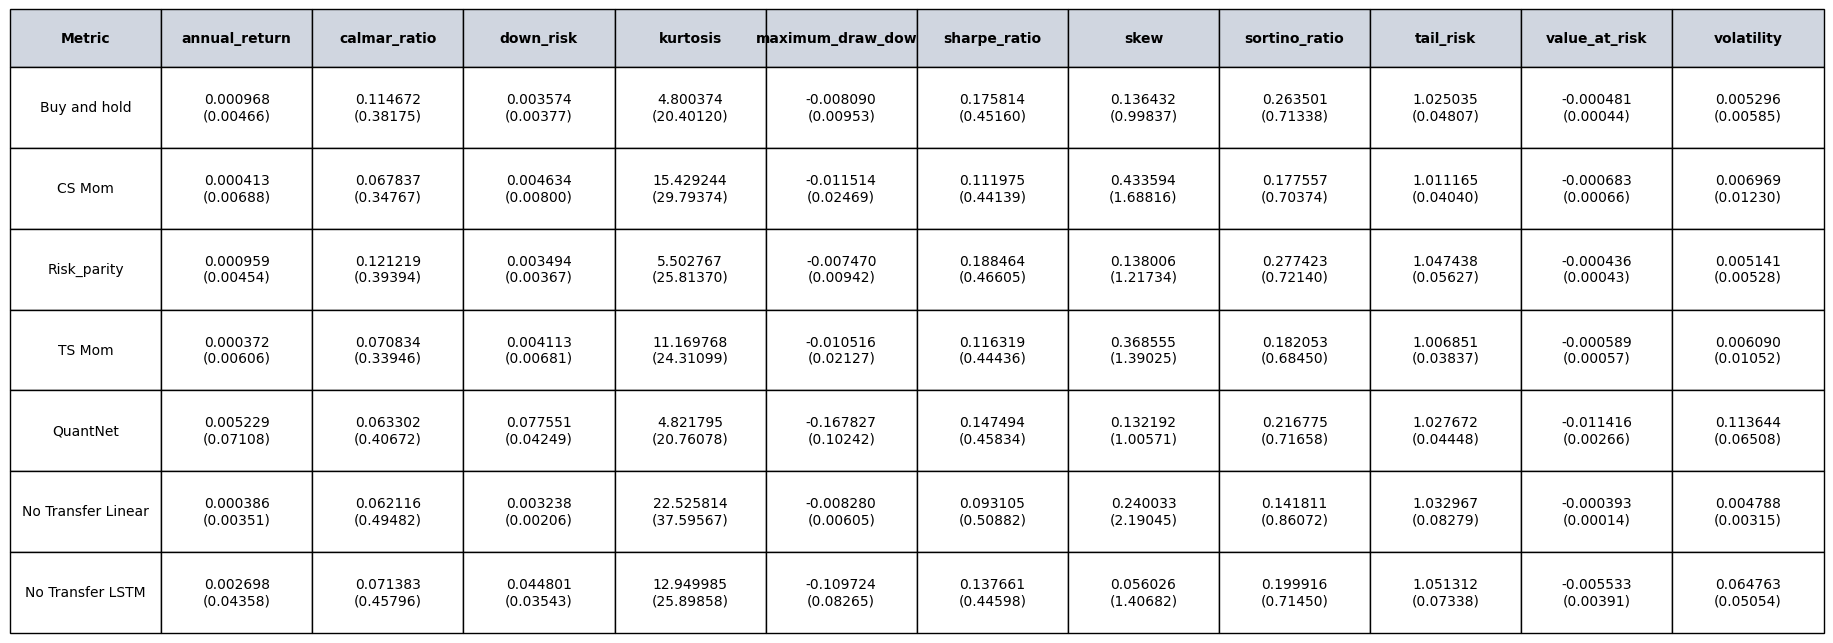

In [ ]:
draw_table(df=table_1, upper_prefix="median", lower_prefix="mad")